In [1]:
import numpy as np
import numba
import scipy.sparse as sp
import matplotlib.pyplot as plt
import sys
import os

from eigenwell.src import grid, grid_preconditioner, boundary_conditions
from eigenwell.src.constants import *

#import eigenwell.boundary
print(os.listdir())


['2d photonic crystal.ipynb', 'check_pml.ipynb', '3D waveguide solve.ipynb', '__init__.py', 'modes of a waveguide.ipynb', 'IMI-MIM.ipynb', 'test_pml_grid_preconditioners.ipynb', '.ipynb_checkpoints', '1D Bragg Mirror.ipynb']


## Equations for a general waveguide with propagation constant $\beta$ in z
\begin{equation}
    \omega^2 \mu_0 T_{\epsilon_y}h_x - T_{\epsilon_y} D_y^{f}T_{\epsilon_z}^{-1}\bigg(D_x^{b}h_y - D_y^{b}h_x\bigg) + D_x^{b}\bigg(D_x^{f}h_x - D_y^{f}h_y \bigg) = \beta^2 h_x
\end{equation}
\begin{equation}
    \omega^2 \mu_0 T_{\epsilon_y}h_x - T_{\epsilon_y} D_y^{f}T_{\epsilon_z}^{-1}\bigg(D_x^{b}h_y - D_y^{b}h_x\bigg) + D_x^{b}\bigg(D_x^{f}h_x - D_y^{f}h_y \bigg) = \beta^2 h_x
\end{equation}

In full operator notation
\begin{equation}
    \omega^2 \mu_0 \begin{bmatrix}
        T_{\epsilon_y} & \\
        & T_{\epsilon_x} 
    \end{bmatrix}
    +
    \begin{bmatrix}
        T_{\epsilon_y} & \\
        & T_{\epsilon_x} 
    \end{bmatrix}     \begin{bmatrix}
        -D_y^{f} \\
        D_x^{f}
    \end{bmatrix} T_{\epsilon_z}^{-1} \begin{bmatrix}
        -D_y^{b} &
        D_x^{b}
    \end{bmatrix} +\begin{bmatrix}
        D_x^{b} \\
        D_y^{b}
    \end{bmatrix} \begin{bmatrix}
        D_x^{f} &
        D_y^{f}
    \end{bmatrix}
\end{equation}



In [2]:
def grid_average(center_array, w):
    '''
        center_array, 1d eps_r
    '''
    # computes values at cell edges

    xy = {'x': 0, 'y': 1}
    center_shifted = np.roll(center_array, 1, axis=xy[w])
    avg_array = (center_shifted+center_array)/2
    return avg_array

[-5e-07, 5e-07]


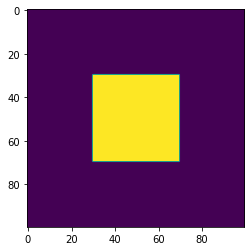

(20000, 10000)
(20000, 20000) <class 'scipy.sparse.csr.csr_matrix'>
1.8836715459105513 1.2566370614359173e-06 110880


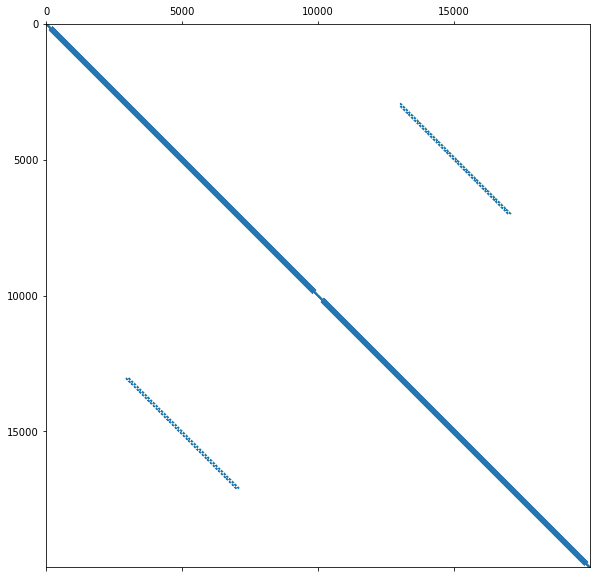

In [4]:
L0 = 1e-6

N = [100,100]
Npml = [5,5]
dL = [0.01*L0, 0.01*L0]
Lx, Ly = [N[0]*dL[0], N[1]*dL[1]]
xrange = [-Lx/2, Lx/2]
yrange = [-Ly/2, Ly/2]
print(xrange)

wvlen = 1e-6;

omega = 2*np.pi*C0/wvlen;

pml = grid_preconditioner.PML(N,Npml, omega);
pml.Soperators(xrange, yrange);

pec_pmc = boundary_conditions.PEC_PMC(N);

epsilon = np.ones(N)
epsilon[30:70, 30:70] = 5
plt.figure();
plt.imshow(epsilon);
plt.show();
M = np.prod(N)
epxx= grid_average(epsilon,'x')
epyy = grid_average(epsilon, 'y')

Tez = sp.diags(EPSILON0*epsilon.flatten(), 0, (M,M))
Tey = sp.diags(EPSILON0*epyy.flatten(), 0, (M,M))
Tex = sp.diags(EPSILON0*epxx.flatten(), 0,(M,M))
invTez = sp.diags(1/(EPSILON0*epsilon.flatten()), 0, (M,M))

fd = grid.FiniteDifference(dL,N)

fd.make_derivatives(PML = pml, PEC_PMC = pec_pmc)
Dxf = fd.Dxf;
Dxb = fd.Dxb;
Dyf = fd.Dyf;
Dyb = fd.Dyb;

## generate operator
Dop1 = sp.bmat([[-Dyf], [Dxf]])
print(Dop1.shape)

Dop2 = sp.bmat([[-Dyb,Dxb]])

Dop3 = sp.bmat([[Dxb], [Dyb]])

Dop4 = sp.bmat([[Dxf,Dyf]])

Tep = sp.block_diag((Tey, Tex))


A = omega**2*MU0*Tep + Tep@(Dop1)@invTez@(Dop2) + Dop3@Dop4

print(A.shape, type(A))
plt.figure(figsize = (10,10))
plt.spy(A, markersize = 0.1)
#plt.spy(Tep@(Dop1)@invTez@(Dop2), markersize = 0.1)

print(omega*1e-15, MU0, A.count_nonzero())

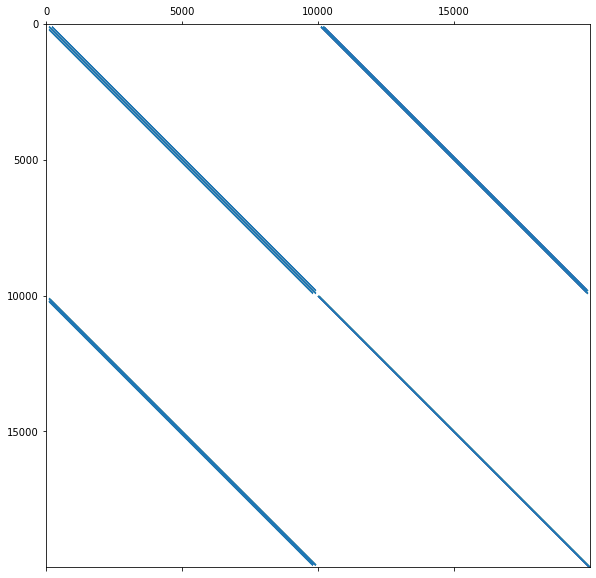

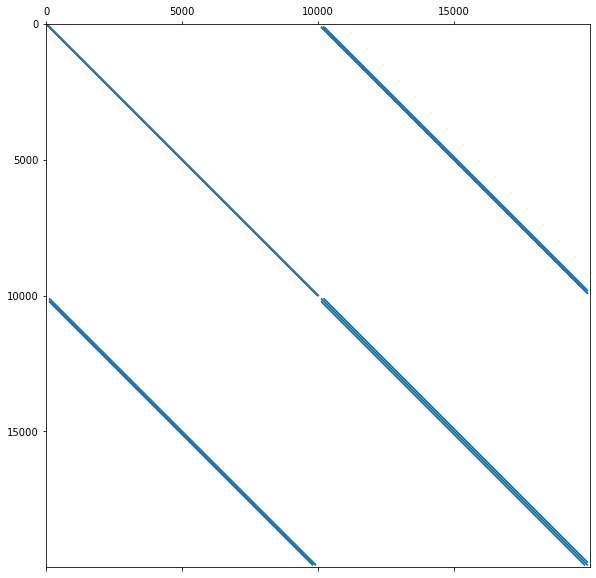

In [5]:
## matrix operations
plt.figure(figsize = (10,10))
plt.spy((Dop1)@invTez@(Dop2), markersize = 0.1)
plt.figure(figsize = (10,10))
plt.spy((Dop3@Dop4), markersize = 0.1)

In [10]:
## use eigs
from scipy.sparse.linalg import eigs
K = 12
print(A.shape)

neff = np.sqrt(np.max(np.real(epsilon)));
beta_est = abs(2*np.pi*neff / (wvlen));
sigma = beta_est**2;

print(sigma)

vals, vecs = eigs(A, k = K, sigma = sigma)

(20000, 20000)
197392088021787.22


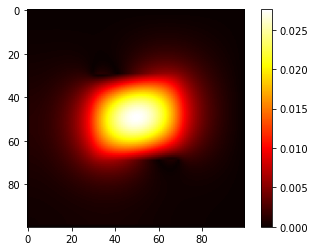

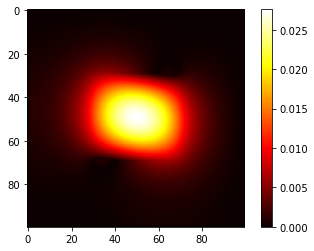

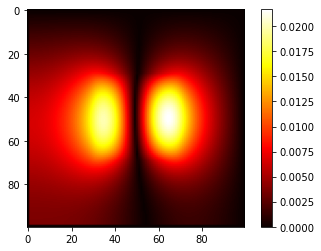

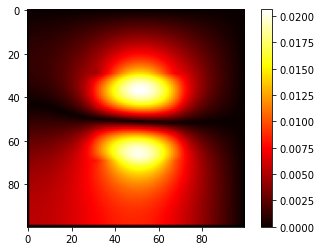

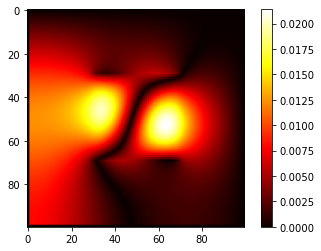

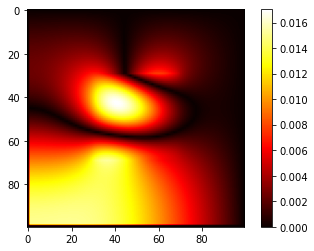

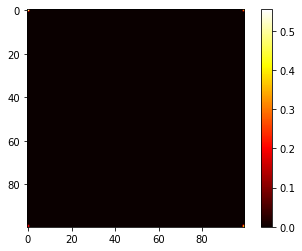

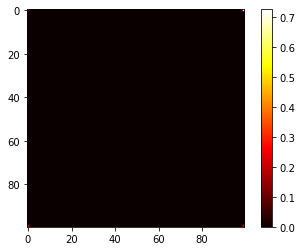

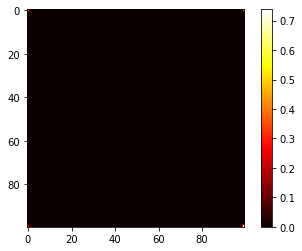

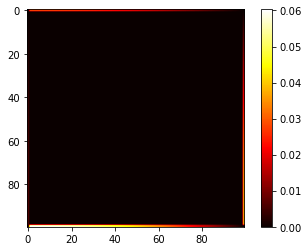

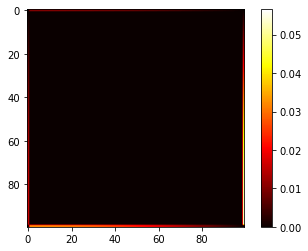

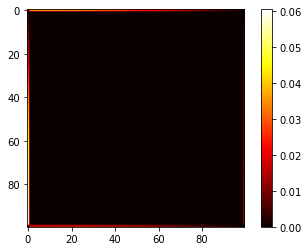

In [12]:
for i in range(K):
    v = vecs[:,i]
    hx = v[0:np.prod(N)].reshape(N)
    hy = v[np.prod(N):].reshape(N)
    plt.figure();
    plt.imshow(np.abs(hx), cmap = 'hot')
    plt.colorbar();

In [9]:
print(vals)

[ 1.62274351e+13+0.00000000e+00j  8.47768936e+12+0.00000000e+00j
  7.91859663e+12+0.00000000e+00j  3.55419488e+12+0.00000000e+00j
 -1.47910390e+12+0.00000000e+00j -1.36371077e+13+4.94253838e+12j
 -1.36371077e+13-4.94253838e+12j  1.65946796e+13+0.00000000e+00j
  1.65946796e+13+0.00000000e+00j  1.65946796e+13+0.00000000e+00j
  1.65946796e+13+0.00000000e+00j  1.65946796e+13+0.00000000e+00j]
